In [1]:
import sys
sys.path.append("..")

import os
import numpy as  np
import matplotlib.pyplot as plt
from pathlib import Path
import kikuchipy as kp
from orix.quaternion import Rotation
from src import io, optimization, rkp, stagecomputation

In [2]:
optimized_correction_coefficients = {'tiltX_corr_angle': -0.5312103261068537, 
                                     'tiltY_corr_angle': 1.2285403872457656, 
                                     'tiltZ_corr_angle': 0.06380671840706255, 
                                     'PCz': 3.890243796249578}

In [3]:
# Path to Si ECP reference pattern
si_ref_ecp_path = Path("../data/fcc_fe/")
si_ref_ecp_file = "01_Si_ref.tif"
si_ref_ecp_fname = os.path.join(si_ref_ecp_path, si_ref_ecp_file)
ref_ecp = plt.imread(si_ref_ecp_fname)

In [4]:
# Path to fcc_Fe master pattern generated by EMsoft
fe_MP_path = Path("../data/ebsd_master_pattern/")
fe_MP_file = "Fe-master-20kV-1.h5"
fe_MP_fname = os.path.join(fe_MP_path, fe_MP_file)
fe_MP = kp.load(fe_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to fcc_Fe .ctf file containing the EBSD euler angles
fe_xmap_path = Path("../data/ebsd_map/")
fe_xmap_file = "20kv_26nA_15mm WD_4x4 bin_fcc_Fe Map.ctf"
fe_xmap_fname = os.path.join(fe_xmap_path, fe_xmap_file)
fe_xmap = io.load_xmap(fe_xmap_fname)

# Reference overview image 
sem_path = Path("../data/fcc_fe")
sem_file = "01_steel overview.tif"
sem_fname = os.path.join(sem_path, sem_file)

In [5]:
correlation = optimization.ipf_image_correlation(sem_fname, fe_xmap_fname)

Phase     Orientations         Name  Space group  Point group  Proper point group     Color
   -1      8358 (2.5%)  not_indexed         None         None                None         w
    1   322978 (97.5%)     Iron fcc        Fm-3m         m-3m                 432  tab:blue
Properties: bands, error, MAD, BC, BS
Scan unit: um


In [6]:
ipf_map = correlation.get_ipf_map(phase_name="Iron fcc", plot=False)
correlation.load_alignment_points(load_path="alignment_points.pkl")
ipf_warp_blended, _ = correlation.process(plot=False)

24 alignment points have been loaded.


In [7]:
# automated correlation of ECP with low magnification SEM image
fe_ecp_path = Path("../data/fcc_fe/")
fe_ecp_file = "steel_ECP_001.tif"
fe_ecp_fname = os.path.join(fe_ecp_path, fe_ecp_file)
fe_exp_ecp = plt.imread(fe_ecp_fname)

fe_sem_path = Path("../data/fcc_fe/")
fe_sem_file = "steel_SEM_001.tif"
fe_sem_fname = os.path.join(fe_sem_path, fe_sem_file)
fe_exp_sem = plt.imread(fe_sem_fname)

metadata1 = io.get_sem_metadata(sem_fname)
metadata2 = io.get_sem_metadata(fe_ecp_fname)

diff_x = metadata2["stage_x"] - metadata1["stage_x"]
diff_y = metadata2["stage_y"] - metadata1["stage_y"]

diff_pix_x = diff_x / metadata1["pixel_size"]
diff_pix_y = diff_y / metadata1["pixel_size"]

# coordinate of high mag image in the low mag overview image in pixels
centre_x = metadata1["resolution"][0]//2 + diff_pix_x
centre_y = metadata1["resolution"][1]//2 - diff_pix_y

correlation.get_euler_from_sem_coord([centre_x, centre_y])

Euler angles at the image point: [146.9424, 43.4434, 8.305199999999997]


[146.9424, 43.4434, 8.305199999999997]

In [8]:
%matplotlib qt
coord_results = correlation.interactive_blended_xmap(initial_coord=[centre_x, centre_y])

Euler angles at the image point: [146.9424, 43.4434, 8.305199999999997]
Phase name at the image point: <name: Iron fcc. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>


stage rotation: 0.0, stage tilt: 0.0


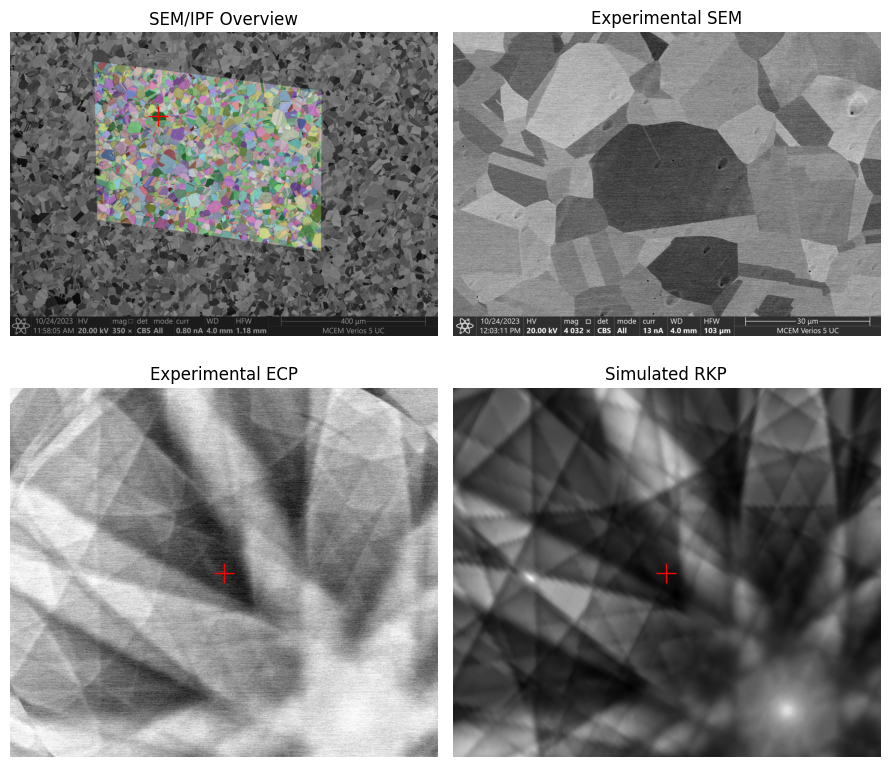

In [9]:
%matplotlib inline
sem_coord = coord_results[0][-1]
euler3 = coord_results[2][-1]
sem_coord, euler3

tiltX_corr_angle_op = optimized_correction_coefficients["tiltX_corr_angle"] # positive direction => pattern moves DOWN
tiltY_corr_angle_op = optimized_correction_coefficients["tiltY_corr_angle"] # positive direction => pattern moves LEFT
tiltZ_corr_angle_op = optimized_correction_coefficients["tiltZ_corr_angle"] # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz_op = optimized_correction_coefficients["PCz"] # Larger value => smaller angular range

# get the stage rotation and tilt relative to the reference ECP
# angles used here are according to the testing reference frame rather than the SEM software rotation and tilt
st_rot_angle, st_tilt_angle = stagecomputation.get_relative_stage_pos(si_ref_ecp_fname, fe_ecp_fname)

# convert the stage rotation and tilt to Rotation objects
# the negative sign is used because the stage rotation and tilt active rotations. 
# In EBSD, rotations are usually in passive form according to Bunge convention
st_rot = Rotation.from_axes_angles(axes = [0, 0, 1], 
                                   angles = -st_rot_angle, 
                                   degrees = True)
st_tilt = Rotation.from_axes_angles(axes = [0, 1, 0], 
                                    angles = -st_tilt_angle, 
                                    degrees=True)

fe_xtal_rotation = Rotation.from_euler(np.deg2rad(euler3)) * Rotation.from_axes_angles([0, 0, 1], -np.pi / 2)
ecp_resolution = io.get_sem_metadata(fe_ecp_fname)["resolution"]


sim_RKP = rkp.get_sim_rkp(RKP_masterpattern = fe_MP,
                              xtal_rotation = fe_xtal_rotation,
                              st_rot_angle = st_rot_angle,
                              st_tilt_angle = st_tilt_angle,
                              corr_angles=[tiltX_corr_angle_op, tiltY_corr_angle_op, tiltZ_corr_angle_op],
                              ref_ECP=si_ref_ecp_fname,
                              cam_length=PCz_op,
                              RKP_shape=ecp_resolution)

fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
axs[0,0].imshow(ipf_warp_blended)
axs[0,0].plot(sem_coord[0], sem_coord[1], 'r+', markersize=14)
axs[0,0].set_title("SEM/IPF Overview")
axs[0,0].axis("off")

axs[0,1].imshow(fe_exp_sem, cmap="gray")
axs[0,1].set_title("Experimental SEM")
axs[0,1].axis("off")

axs[1,0].imshow(fe_exp_ecp[:ecp_resolution[1],:], cmap='gray')
axs[1,0].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,0].set_title("Experimental ECP")
axs[1,0].axis("off")

axs[1,1].imshow(np.squeeze(sim_RKP.data), cmap='gray')
axs[1,1].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,1].set_title("Simulated RKP")
axs[1,1].axis("off")

plt.tight_layout()
print(f"stage rotation: {np.round(st_rot_angle, 2)}, stage tilt: {np.round(st_tilt_angle, 2)}")